# Database examples

## Import libraries

In [1]:
from IPhreeqcPy import IPhreeqc

In [2]:
import urllib.request

In [3]:
import pandas as pd

In [4]:
import numpy as np

## Load PHREEQC and database

In [5]:
p=IPhreeqc()

In [6]:
urllib.request.urlretrieve('http://scicorner.com/askja/askja.dat', 'askja.dat')

('askja.dat', <http.client.HTTPMessage at 0x1f4d9939148>)

In [7]:
p.LoadDatabase('askja.dat')

## Seawater speciation

In [8]:
p.RunString('''
SELECTED_OUTPUT
    -reset false
    -molalities Na+ NaSO4- NaHCO3 NaCO3-
        Mg+2 MgSO4 MgHCO3+ MgCO3
        Ca+2 CaSO4 CaHCO3+ CaCO3
        K+ KSO4-

SOLUTION 1
    units mol/kgw
    temp 25
    pH 8.04
    density 1.023
    Na 0.4860597
    Mg 0.0547421
    Ca 0.0106568
    K  0.0105797
    Cl 0.5657647
    S(6) 0.0292643
    Alkalinity 0.0023
''')

In [9]:
res = p.GetSelectedOutputArray()
res = pd.DataFrame(pd.Series(data=res[1], index=res[0], name='Conc. / mol/kgw'))
res['Element'] = [
    'Na', 'Na', 'Na', 'Na',
    'Mg', 'Mg', 'Mg', 'Mg',
    'Ca', 'Ca', 'Ca', 'Ca',
    'K', 'K'
]
res['Anion'] = [
    'Free', 'Sulfate', 'Bicarbonate', 'Carbonate',
    'Free', 'Sulfate', 'Bicarbonate', 'Carbonate',
    'Free', 'Sulfate', 'Bicarbonate', 'Carbonate',
    'Free', 'Sulfate'
]

In [10]:
totals = res.groupby('Element')['Conc. / mol/kgw'].sum()

In [11]:
res['Rel. conc / %'] = res.apply(lambda x: x['Conc. / mol/kgw'] / totals[x['Element']] * 100, axis=1)

In [12]:
pivot = res.pivot(index='Element', columns='Anion', values='Rel. conc / %')
pivot

Anion,Bicarbonate,Carbonate,Free,Sulfate
Element,,,,
Ca,0.343991,0.215973,90.556968,8.883069
K,NaN,NaN,97.903093,2.096907
Mg,0.498011,0.155163,85.395770,13.951056
Na,0.049093,0.005979,98.449625,1.495304


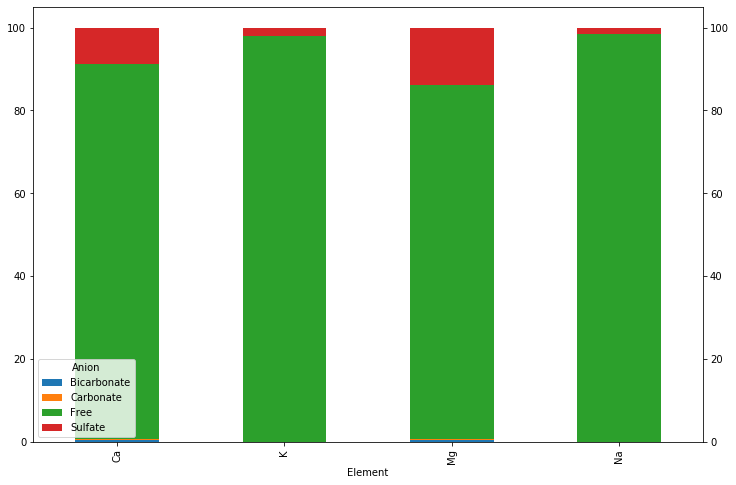

In [13]:
pivot.plot.bar(stacked=True, figsize=[12, 8])

## Elemental speciation as function of pH

In [14]:
test = ['Al+3','Al(OH)3']

In [15]:
' '.join(test)

'Al+3 Al(OH)3'

In [16]:
def CalcSpeciation(element, species, temp=25, pHRange=[2,12], points=50):
    pHList = np.linspace(pHRange[0], pHRange[1], points)
    cList = {}
           
    for pH in pHList:
        p.RunString('''
        SELECTED_OUTPUT
            -reset false
            -high_precision true
            -molalities ''' + ' '.join(species) + '''
            
        PHASES
        pH_FIX
              H+=H+
              log_k 0
        
        SOLUTION 1
            temp ''' + str(temp) + '''
            units mol/kgw
            ''' + element + ''' 1e-6

        EQUILIBRIUM_PHASES 1
            pH_FIX ''' + str(-1 * pH) + ''' ''' + ('NaOH' if pH > 7 else 'HCl') + '''
        ''')
        
        res = p.GetSelectedOutputArray()
        
        cList[pH] = res[2]
        
    cList = pd.DataFrame(cList, index=species).T
    
    cList = cList.div(cList.sum(axis=1), axis=0)
        
    return cList

### Aluminium

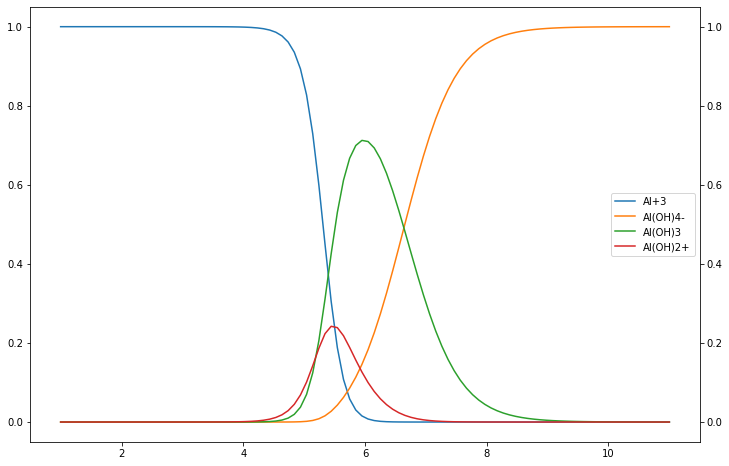

In [17]:
AlSpec = CalcSpeciation(element='Al', species=['Al+3','Al(OH)4-','Al(OH)3','Al(OH)2+'], temp=25, pHRange=[1,11], points=100)
AlSpec.plot()

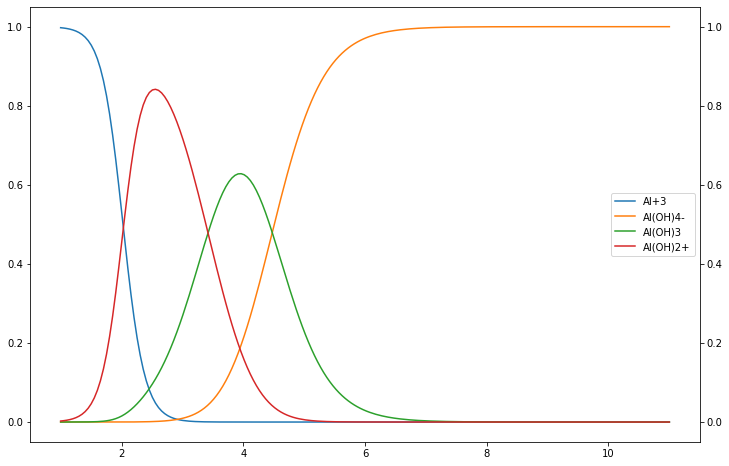

In [18]:
AlSpec = CalcSpeciation(element='Al', species=['Al+3','Al(OH)4-','Al(OH)3','Al(OH)2+'], temp=200, pHRange=[1,11], points=200)
AlSpec.plot()

### Carbon

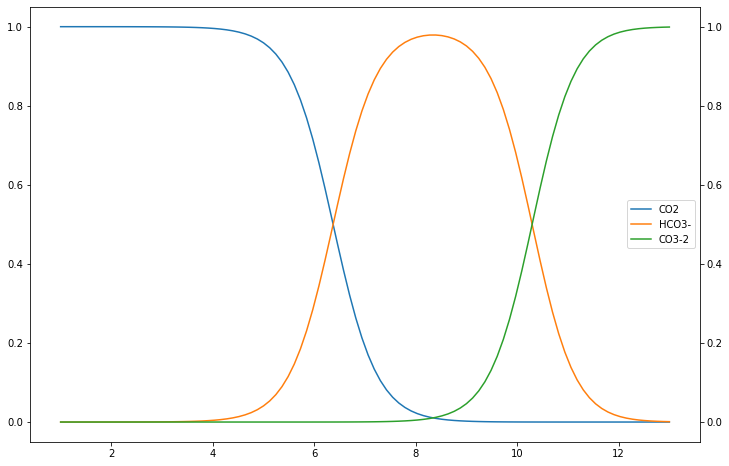

In [19]:
CSpec = CalcSpeciation(element='C', species=['CO2','HCO3-','CO3-2'], temp=25, pHRange=[1,13], points=100)
CSpec.plot()